In [1]:
%pylab qt
from scipy.integrate import solve_ivp
from IPython import display
import time
import scipy.integrate as integrate

Populating the interactive namespace from numpy and matplotlib


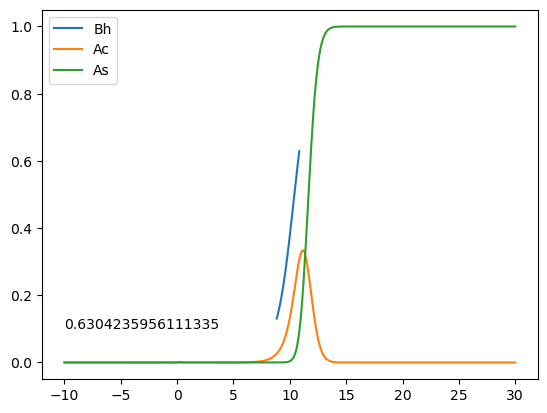

In [3]:
#Euler numerical method (no curviture)

# define domain and lattice
dx = 0.1
dt = 0.001
tf = 400.0
t_max = int(tf/dt)
Lmax = 30.0 
Lmin = -10.0
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)



a0 = 1.0
nu = 0.9
h0 = 2.0

hubRad = 1.0
NHub = int((2.0*hubRad)/dx)  # number of lattice sites that spike proteins can occupy


        

# initialize As and Ac for each run through
As = zeros(Nx)
As[xs > 0.0] = a0*1.0
Ac = zeros(Nx)
BHub0 = h0 * ones(NHub)
BHub = BHub0
xp = 0.0


v_t = []
for t in range(t_max):
    
    leftBdry = xp - hubRad    # left and right boundary for spike protein distribution
    rightBdry = xp + hubRad
    xHub = linspace(leftBdry, rightBdry, NHub)
    
    diffMat = abs(xHub[:,newaxis] - xs)
    expMat = exp(-0.5*diffMat**2)  # NHub by N matrix
    
    PNum = expMat*BHub[:,newaxis]
    
    Pxx = PNum/sum(PNum, axis = 0)  # probability that a given substrate protein binds with hub protein (columns normalized)
    
    #total_f = trapz(trapz(Pxx*diffMat, x = xHub,axis = 0)*Ac, x=xs)
    centerNum = trapz(BHub0-BHub,x=xHub)
    if centerNum < 1e-8:
        BHubCenter = xp
    else:
        BHubCenter = trapz((BHub0-BHub)*xHub,x=xHub)/centerNum
    total_f = -trapz((BHubCenter-xs)*Ac,x=xs)
    binding = trapz(expMat*outer(BHub,As), x=xHub, axis = 0)     
    burnt = nu * Ac
    Ac += (binding - burnt) * dt
    As += - binding * dt
    BHub =  BHub0 - sum(Ac*Pxx, axis = 1) 
    xp += total_f * dt 
    v_t.append(total_f)
    if t % 1000 == 0:
        display.clear_output(wait=True)
        plot(xHub, BHub0-BHub, label = 'Bh')
        plot(xs,Ac, label = 'Ac')
        plot(xs,As, label = 'As')
        #axvline(x=xp, color = "red")
        #axvline(x=BHubCenter, color = "green")
        text(-10,0.1,total_f)
        legend()
        display.display(gcf())
        cla()
        
        #input("Press enter to continue")
    if xp >= 10.0:
        plot(xHub, BHub0-BHub, label = 'Bh')
        plot(xs,Ac, label = 'Ac')
        plot(xs,As, label = 'As')
        legend()
        break

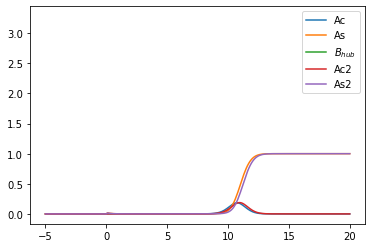

1


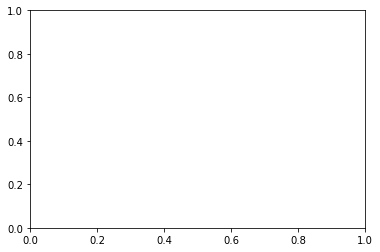

In [2]:
#Euler method with curviture 
#comparing with point-like hub

# define domain and lattice
dx = 0.1
dt = 0.001
tf = 400.0
t_max = int(tf/dt)
Lmax = 20.0 
Lmin = -5.0
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

a0 = 1.0
nu = 1.0
htot = 100.0 # total hub protein available for binding

def xHubCurv(xp):
    return xp + hubRad * sin(phis)

hubRads = logspace(-1,2,3,base=2)*dx
hubRads = ones(1)*0.05

for hubRad in hubRads:
    phiCrit = pi * 0.5 # substrate can bind anything in [-phiCrit, phiCrit]
    NHub = int((2.0*phiCrit*hubRad)/dx)  # number of lattice sites that spike proteins can occupy
    if NHub == 1:
        phis = zeros(1) # force a single lattice site to be at the hub center (as in the point-like hub case)
    else:
        phis = linspace(-phiCrit,phiCrit,NHub)
    # initialize As and Ac for each run through
    h0 = htot/NHub # amount of available hub protein concentration at each lattice site
    As = zeros(Nx)
    As[xs > 0.0] = a0*1.0
    Ac = zeros(Nx)
    BHub0 = h0 * ones(NHub)
    BHub = BHub0.copy()
    AcBHub = zeros((NHub,Nx))
    xp = 0.0
    
   

    #setup point like hub
    As2 = zeros(Nx)
    As2[xs > 0.0] = a0*1.0
    Ac2 = zeros(Nx)
    xp2 = 0.0
    for t in range(t_max):
        xHub = xHubCurv(xp)
        diffMat = abs(xHub[:,newaxis] - xs)
        stretchMat = sqrt((xp + hubRad*sin(phis[:,newaxis]) - xs)**2 + hubRad**2*(1-cos(phis[:,newaxis]))**2 )
        expMat = exp(-0.5*stretchMat**2)  # NHub by N matrix of boltzmann factors
        
        PNum = expMat*((BHub/BHub0))[:,newaxis]   #boltzmann factor reduced by ratio of sites available

        # find the center of mass for the hub protein distribution
        centerDenom = trapz(BHub0-BHub,x=xHub)
        if centerDenom < 1e-8:# was an issue when centerDenom was zero
            BHubCenter = xp
        else:
            BHubCenter = trapz((BHub0-BHub)*xHub,x=xHub)/centerDenom

        total_f = -trapz((BHubCenter-xs)*Ac,x=xs)
        
        
        AcBHub += (PNum*As- AcBHub*nu) * dt
        for i in range(NHub):
            ii = where(AcBHub[i]< 10**(-8))[0]
            AcBHub[i][ii] = 0.0
        Ac = sum(AcBHub, axis = 0)
        As += - sum(PNum*As, axis = 0) *dt
        BHub = BHub0-sum(AcBHub, axis = 1)
        xp += total_f * dt
        burnt = nu*Ac
        burnrate = trapz(burnt,x=xs)
        eff = total_f**2/burnrate    
        
        total_f2 = -trapz((xp2-xs)*Ac2,x=xs)
        binding2 = exp(-0.5*(xp2-xs)**2)*As2*((htot - trapz(Ac, x=xs))/htot)
        burnt2 = nu * Ac2
        Ac2 += (binding2 - burnt2) * dt
        As2 += - binding2 * dt
        xp2 += total_f2 * dt 
        burnRate2 = trapz(burnt2,x=xs)
        
        if t % 1000 == 0:
            display.clear_output(wait=True)
            plot(xs,Ac, label = 'Ac')
            plot(xs,As, label = 'As')
            plot(xHub, BHub0-BHub, label = '$B_{hub}$')
            plot(xs,Ac2, label = 'Ac2')
            plot(xs,As2, label = 'As2')
            legend()
            display.display(gcf())
            cla()
        
        if xp > Lmax - 10.0:
            break
    
print(NHub)

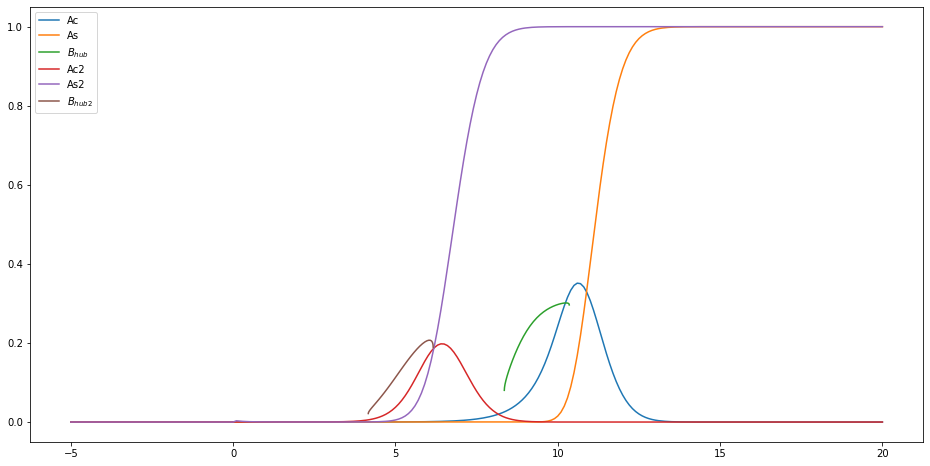

31


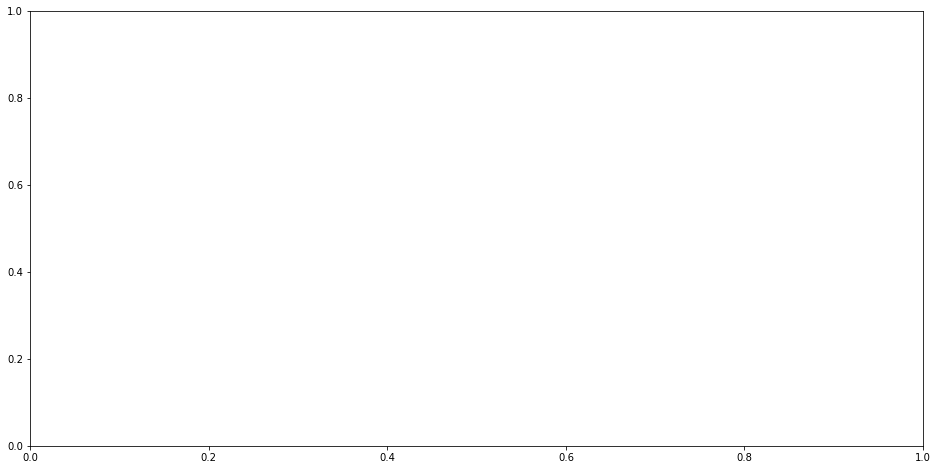

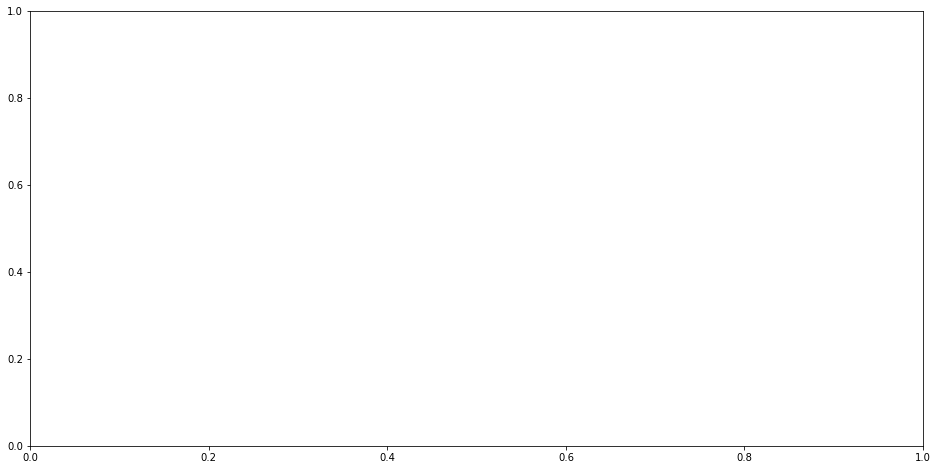

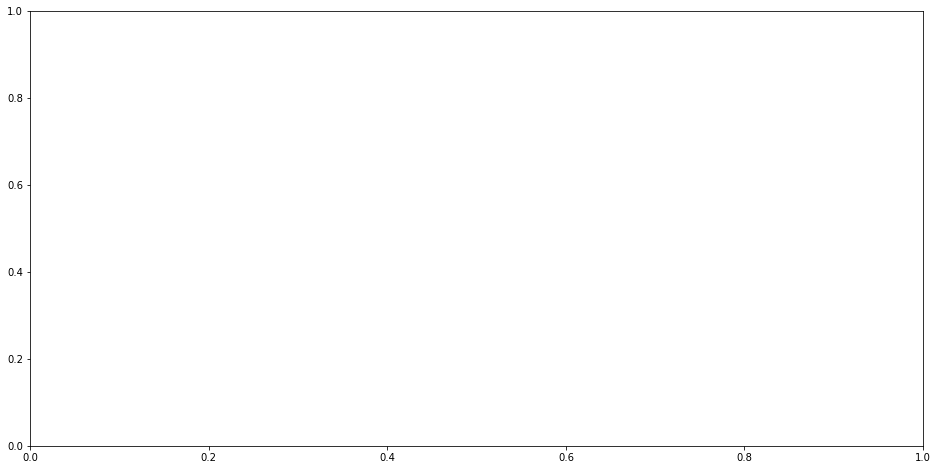

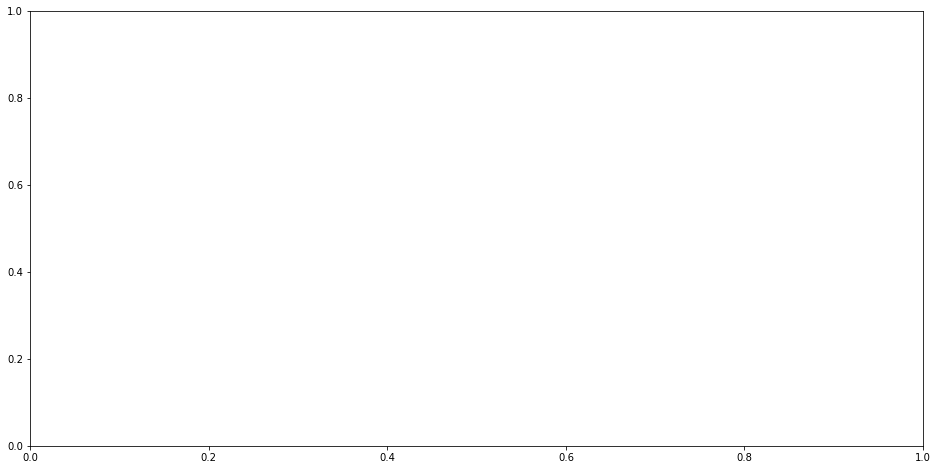

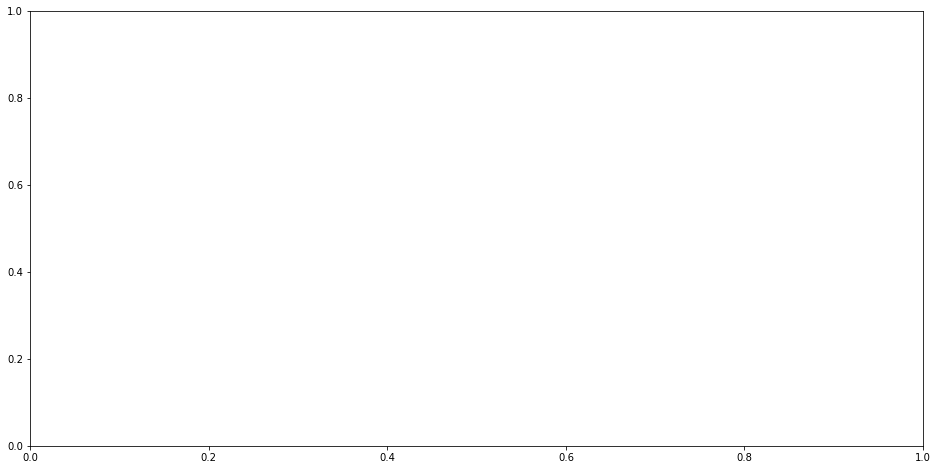

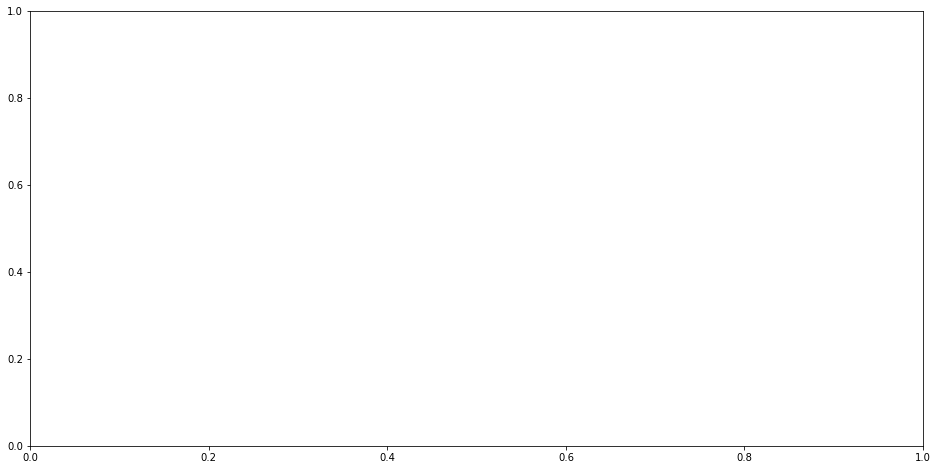

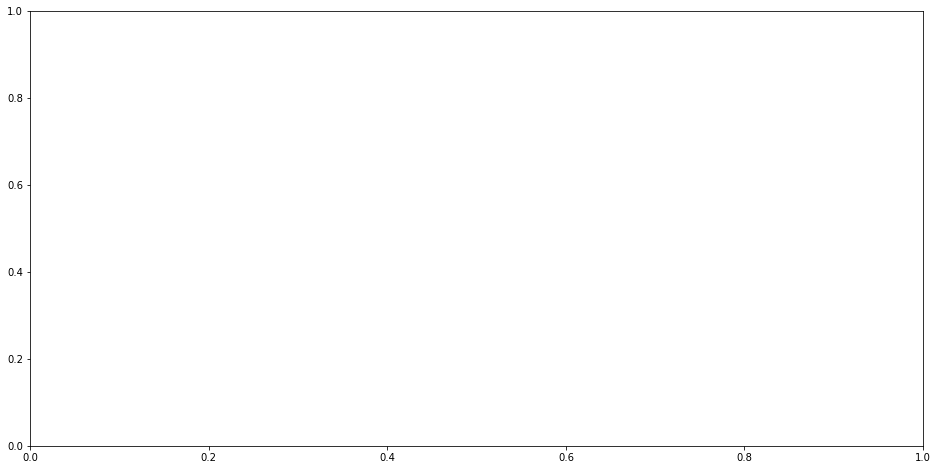

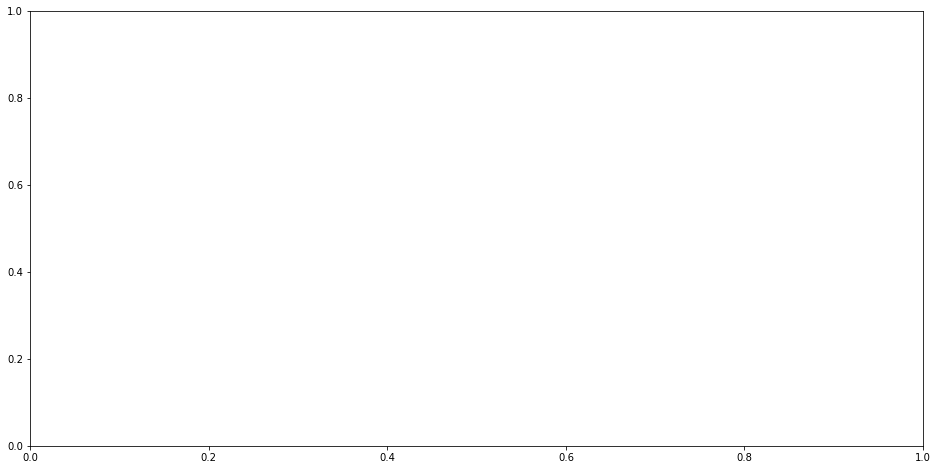

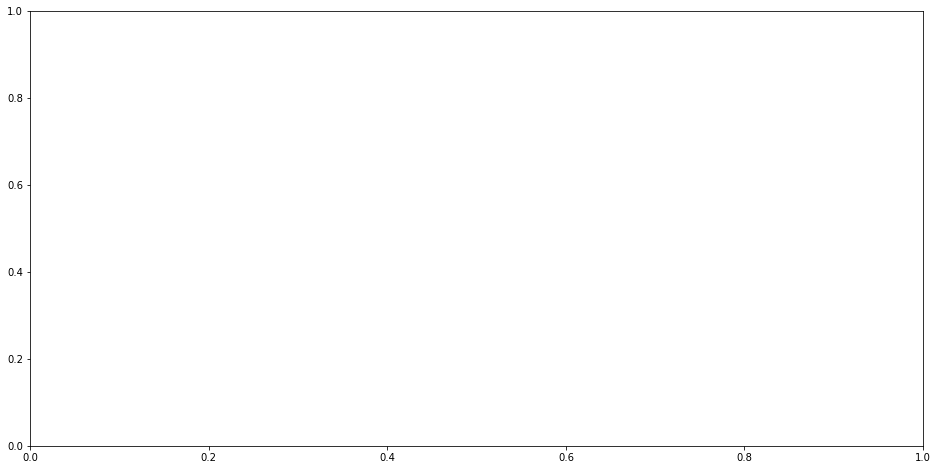

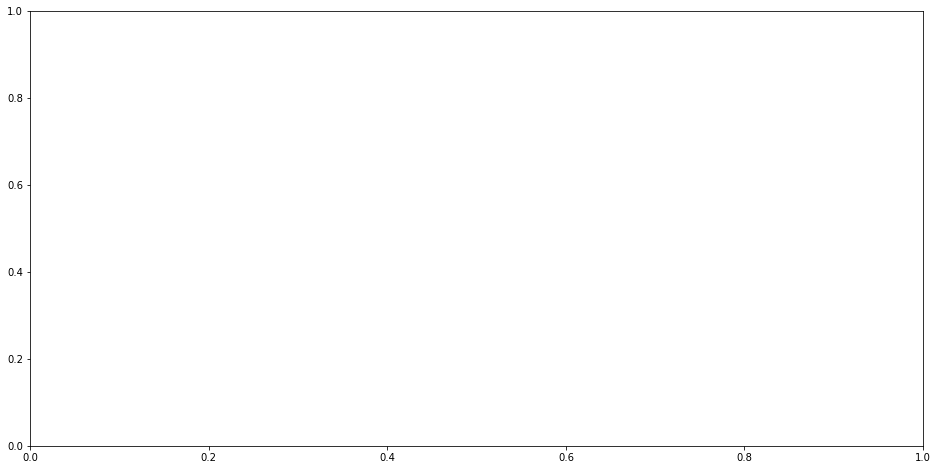

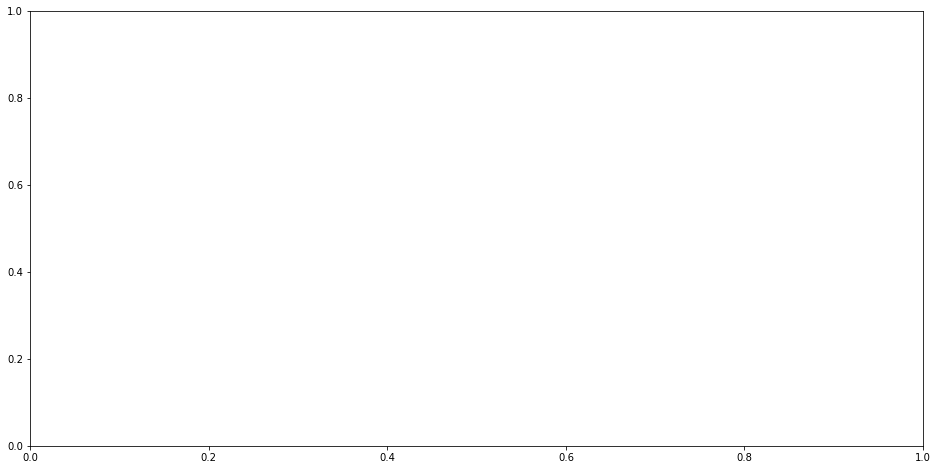

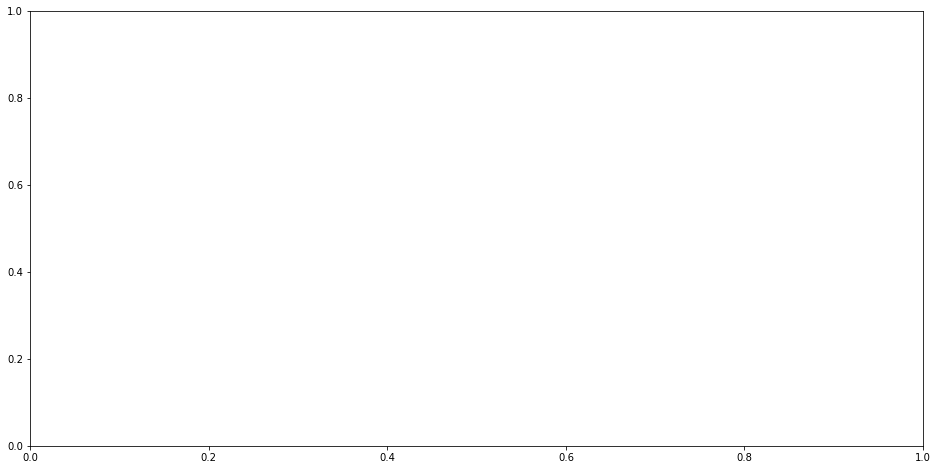

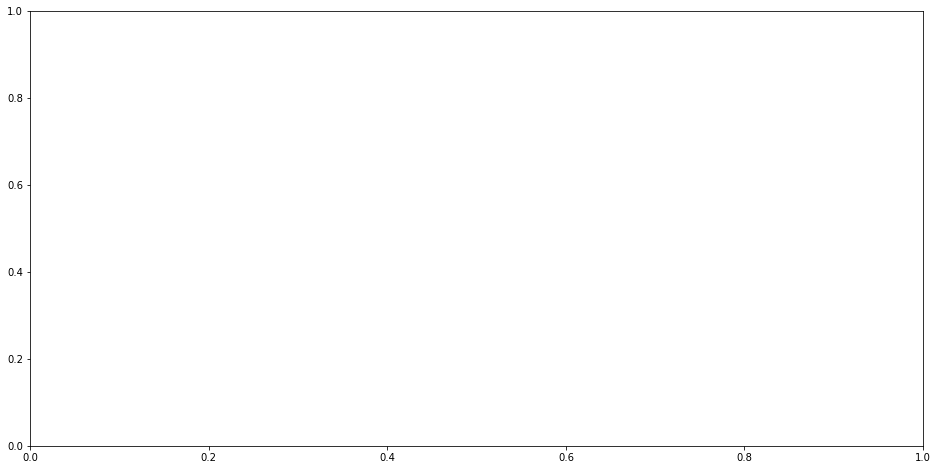

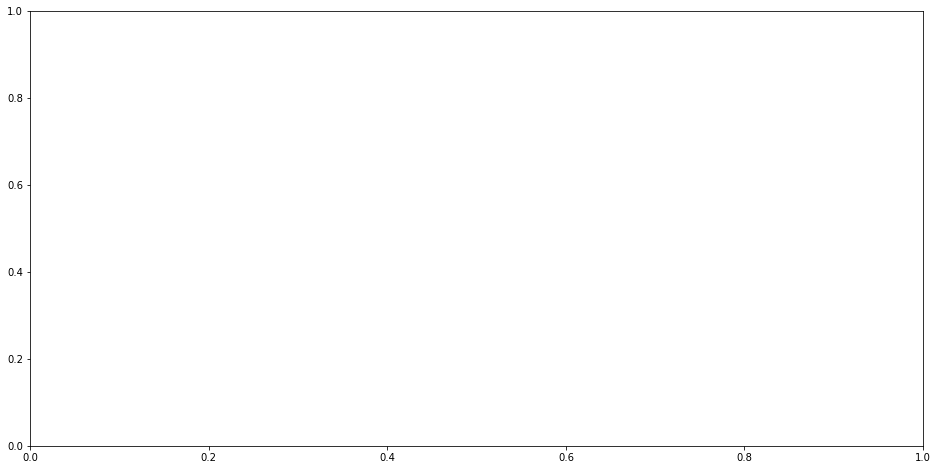

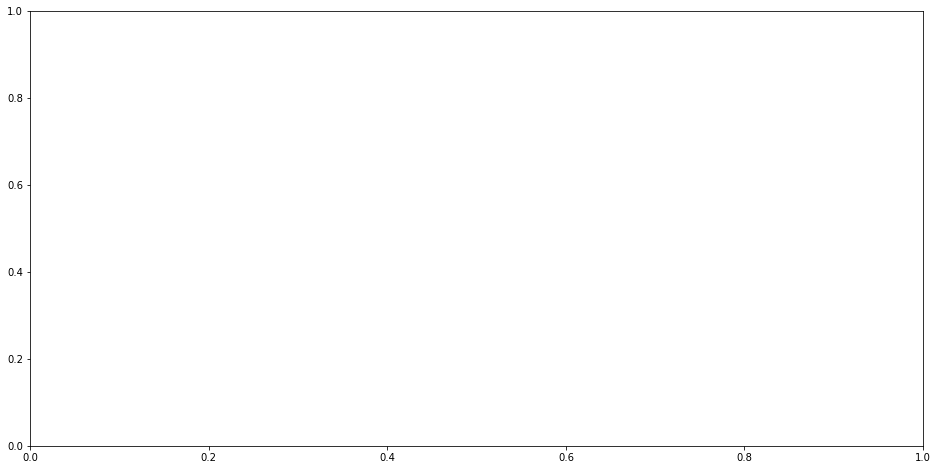

In [4]:
#Euler method with curviture 
#comparing continuum of hub binding sites with discrete binding sites

# define domain and lattice
dx = 0.1
dt = 0.001
tf = 400.0
t_max = int(tf/dt)
Lmax = 20.0 
Lmin = -5.0
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

a0 = 1.0
nu = 1.0
htot = 10.0 # total hub protein available for binding

def xHubCurv(xp):
    return xp + hubRad * sin(phis)

hubRads = logspace(-1,2,3,base=2)*dx
hubRads = ones(1)*1.0

for hubRad in hubRads:
    phiCrit = pi * 0.5 # substrate can bind anything in [-phiCrit, phiCrit]
    NHub = int((2.0*phiCrit*hubRad)/dx)  # number of lattice sites that spike proteins can occupy
    if NHub == 1:
        phis = zeros(1) # force a single lattice site to be at the hub center (as in the point-like hub case)
    else:
        phis = linspace(-phiCrit,phiCrit,NHub)
        
    # initialize As and Ac for each run through
    h0 = htot/NHub # amount of available hub protein concentration at each lattice site
    As = zeros(Nx)
    As[xs > 0.0] = a0*1.0
    Ac = zeros(Nx)
    BHub0 = h0 * ones(NHub)
    BHub = BHub0.copy()
    AcBHub = zeros((NHub,Nx))
    xp = 0.0
    
    h02 = htot/(pi*hubRad)
    As2 = zeros(Nx)
    As2[xs > 0.0] = a0*1.0
    Ac2 = zeros(Nx)
    BHub02 = h02 * ones(NHub)
    BHub2 = BHub02.copy()
    AcBHub2 = zeros((NHub,Nx))
    xp2 = 0.0
    print(h0,h02)
    input()
    for t in range(t_max):
        xHub = xHubCurv(xp)
        stretchMat = sqrt((xp + hubRad*sin(phis[:,newaxis]) - xs)**2 + hubRad**2*(1-cos(phis[:,newaxis]))**2 )
        expMat = exp(-0.5*stretchMat**2)  # NHub by N matrix of boltzmann factors
        
        PNum = expMat*((BHub/BHub0))[:,newaxis]   #boltzmann factor reduced by ratio of sites available

        # find the center of mass for the hub protein distribution
        centerDenom = trapz(BHub0-BHub,x=xHub)
        if centerDenom < 1e-8:# was an issue when centerDenom was zero
            BHubCenter = xp
        else:
            BHubCenter = trapz((BHub0-BHub)*xHub,x=xHub)/centerDenom

        total_f = -trapz((BHubCenter-xs)*Ac,x=xs)
        
        
        AcBHub += (PNum*As- AcBHub*nu) * dt
        for i in range(NHub):
            ii = where(AcBHub[i]< 10**(-8))[0]
            AcBHub[i][ii] = 0.0
        Ac = sum(AcBHub, axis = 0)
        As += - sum(PNum*As, axis = 0) *dt
        BHub = BHub0-sum(AcBHub, axis = 1)
        xp += total_f * dt
        burnt = nu*Ac
        burnrate = trapz(burnt,x=xs)
        eff = total_f**2/burnrate    
        
        
        # for continuum of hub protein sites
        xHub2 = xHubCurv(xp2)
        stretchMat2 = sqrt((xp2 + hubRad*sin(phis[:,newaxis]) - xs)**2 + hubRad**2*(1-cos(phis[:,newaxis]))**2 )
        expMat2 = exp(-0.5*stretchMat2**2)  # NHub by N matrix of boltzmann factors
        
        PNum2 = expMat2*((BHub2/BHub0))[:,newaxis]   #boltzmann factor reduced by ratio of sites available

        # find the center of mass for the hub protein distribution
        centerDenom2 = trapz(BHub0-BHub2,x=xHub2)
        if centerDenom < 1e-8:# was an issue when centerDenom was zero
            BHubCenter2 = xp2
        else:
            BHubCenter2 = trapz((BHub0-BHub2)*xHub2,x=xHub2)/centerDenom2

        total_f2 = -trapz((BHubCenter2-xs)*Ac2,x=xs)
        
        
        AcBHub2 += (PNum2*As2- AcBHub2*nu) * dt
        for i in range(NHub):
            ii = where(AcBHub2[i]< 10**(-8))[0]
            AcBHub2[i][ii] = 0.0
        Ac2 = trapz(AcBHub2, x=phis, axis = 0)
        As2 += - trapz(PNum2*As2, x=phis, axis = 0) *dt
        BHub2 = BHub0-trapz(AcBHub2, x=xs, axis = 1)
        xp2 += total_f2 * dt
        burnt2 = nu*Ac2
        burnrate2 = trapz(burnt2,x=xs)
        eff2 = total_f2**2/burnrate2 
        
        if t % 1000 == 0:
            fig, axs = plt.subplots(figsize = (16,8))
            display.clear_output(wait=True)
            plot(xs,Ac, label = 'Ac')
            plot(xs,As, label = 'As')
            plot(xHub, BHub0-BHub, label = '$B_{hub}$')
            plot(xs,Ac2, label = 'Ac2')
            plot(xs,As2, label = 'As2')
            plot(xHub2, BHub0-BHub2, label = '$B_{hub2}$')
            legend()
            display.display(gcf())
            cla()
        
        if xp > Lmax - 10.0:
            break
    
print(NHub)

In [8]:
#Euler method with curviture 
#comparing for different hubRads

# define domain and lattice
dx = 0.1
dt = 0.001
tf = 400.0
t_max = int(tf/dt)
Lmax = 20.0 
Lmin = -5.0
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

a0 = 1.0
nu = 1.0
htot = 100.0 # total hub protein available for binding

def xHubCurv(xp):
    return xp + hubRad * sin(phis)

hubRad_n = 2
hubRads = logspace(-3,0,hubRad_n,base=2)
hubRads= ones(1)

eff_Rad = []
for hubRad in hubRads:
    phiCrit = pi * 0.5 # substrate can bind anything in [-phiCrit, phiCrit]
    NHub = int((2.0*phiCrit*hubRad)/dx)  # number of lattice sites that spike proteins can occupy
    if NHub == 1:
        phis = zeros(1) # force a single lattice site to be at the hub center (as in the point-like hub case)
    else:
        phis = linspace(-phiCrit,phiCrit,NHub)
   
    h0 = htot/(pi*hubRad)
    As = zeros(Nx)
    As[xs > 0.0] = a0*1.0
    Ac = zeros(Nx)
    BHub0 = h0 * ones(NHub)
    BHub = BHub0.copy()
    AcBHub = zeros((NHub,Nx))
    xp = 0.0
    for t in range(t_max):
        
        xHub = xHubCurv(xp)
        stretchMat = sqrt((xp + hubRad*sin(phis[:,newaxis]) - xs)**2 + hubRad**2*(1-cos(phis[:,newaxis]))**2 )
        expMat = exp(-0.5*stretchMat**2)  # NHub by N matrix of boltzmann factors
        
        PNum = expMat*((BHub/BHub0))[:,newaxis]   #boltzmann factor reduced by ratio of sites available

        # find the center of mass for the hub protein distribution
        centerDenom = trapz(BHub0-BHub,x=xHub)
        if centerDenom < 1e-8:# was an issue when centerDenom was zero
            BHubCenter = xp
        else:
            BHubCenter = trapz((BHub0-BHub)*xHub,x=xHub)/centerDenom

        total_f = -trapz((BHubCenter-xs)*Ac,x=xs)/hubRad
        
        
        AcBHub += (PNum*As- AcBHub*nu) * dt
        for i in range(NHub):
            ii = where(AcBHub[i]< 10**(-8))[0]
            AcBHub[i][ii] = 0.0
        Ac = trapz(AcBHub, x=phis, axis = 0)
        As += - trapz(PNum*As, x=phis, axis = 0) *dt
        BHub = BHub0-trapz(AcBHub, x=xs, axis = 1)
        xp += total_f * dt
        burnt = nu*Ac
        burnrate = trapz(burnt,x=xs)
        eff = total_f**2/burnrate 
        '''  
        if t % 1000 == 0:
            fig, axs = plt.subplots(figsize = (16,8))
            display.clear_output(wait=True)
            plot(xs,Ac, label = 'Ac')
            plot(xs,As, label = 'As')
            plot(xHub, BHub0-BHub, label = '$B_{hub}$')
            text(Lmin,0.1*a0,str(round(hubRad,2))+str(round(eff,2)))
            ylabel("Concentration")
            xlabel("Position")
            legend()
            display.display(gcf())
            cla()'''
        
        if xp > Lmax - 10.0:
            eff_Rad.append(eff)
            plot(xHub, BHub0-BHub, label = '$B_{hub}$')
            #plot(xs,Ac, label = 'Ac')
            #plot(xs,As, label = 'As')
            ylabel("Concentration")
            xlabel("Position")
            legend()
            break
    

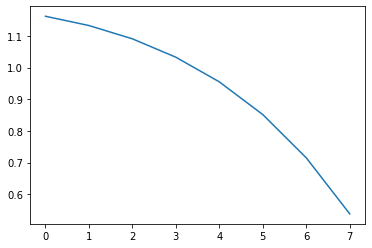

In [10]:
plot(eff_Rad)

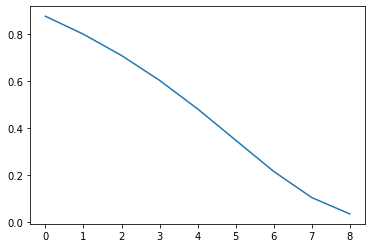

In [11]:
plot(eff_Rad)

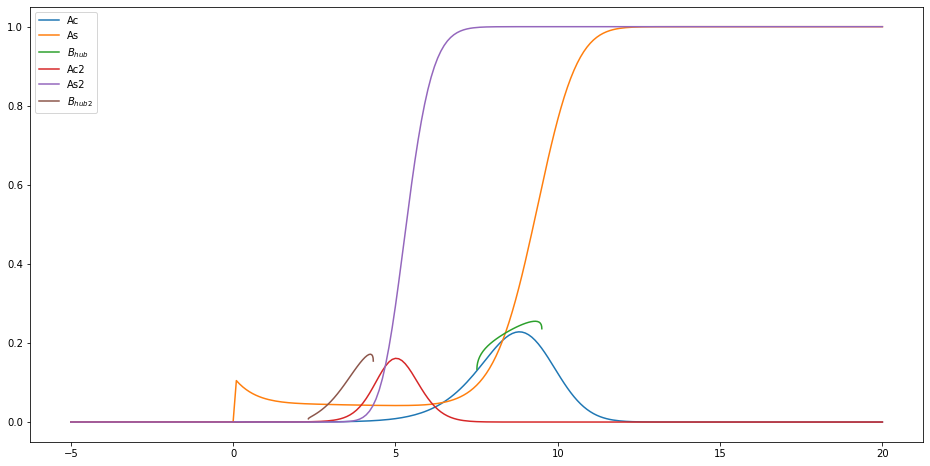

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-6b6002a7139b>", line 73, in <module>
    Ac = trapz(AcBHub, x=phis, axis = 0)
  File "<__array_function__ internals>", line 5, in trapz
  File "C:\Users\mark-\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py", line 4088, in trapz
    ret = (d * (y[tuple(slice1)] + y[tuple(slice2)]) / 2.0).sum(axis)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2061, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call 

TypeError: object of type 'NoneType' has no len()

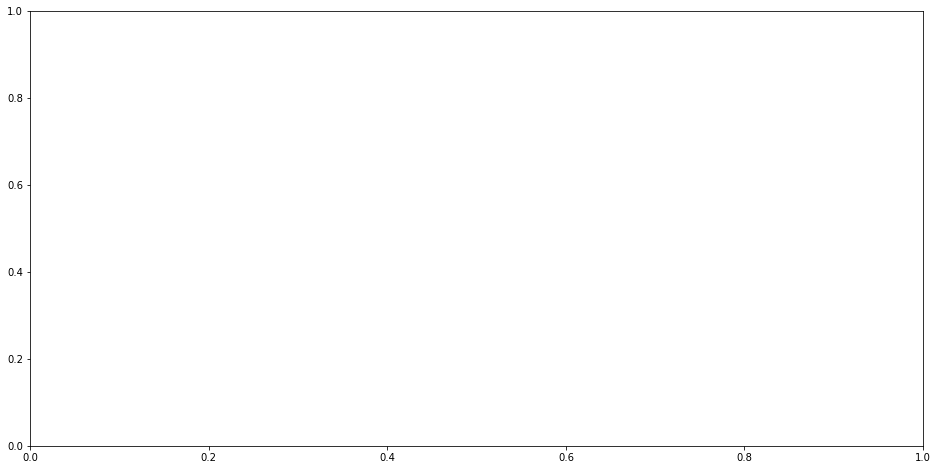

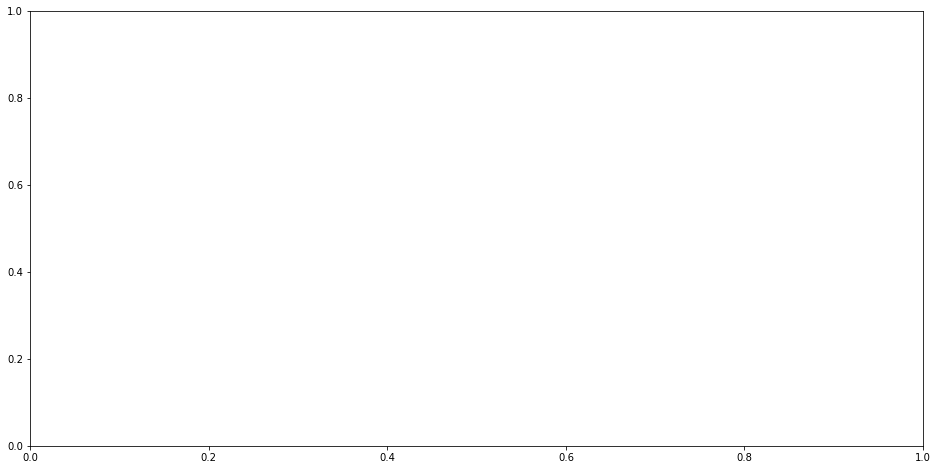

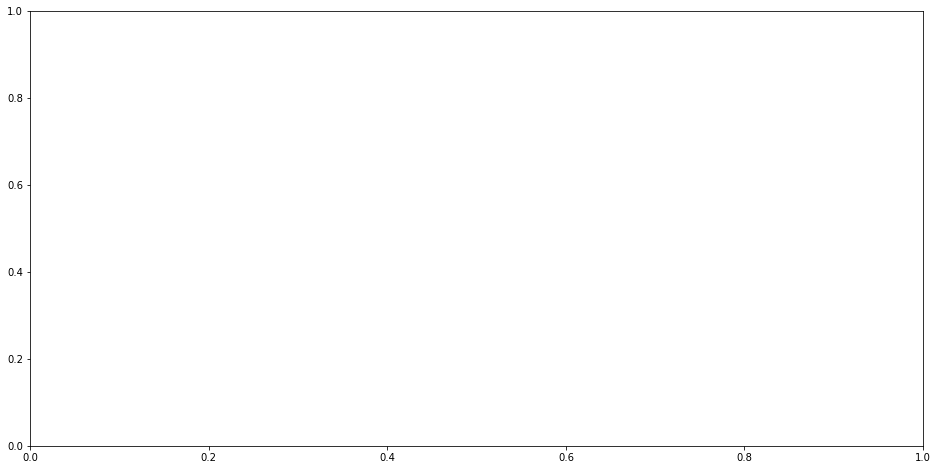

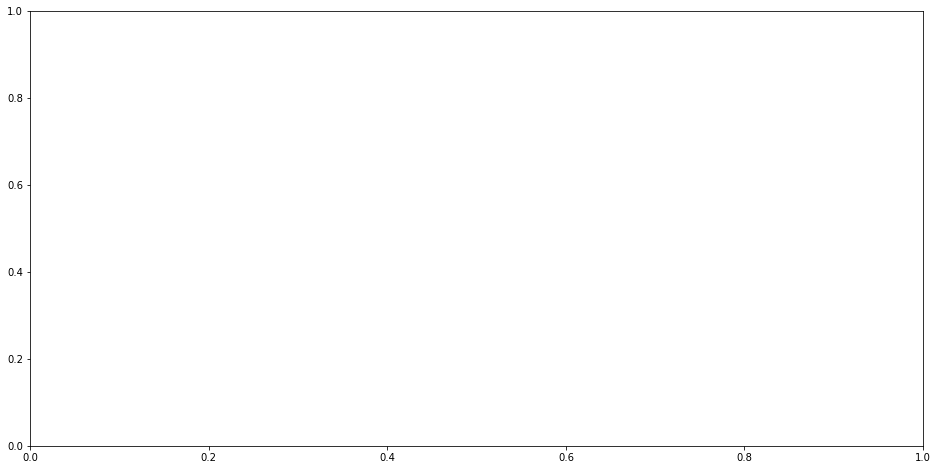

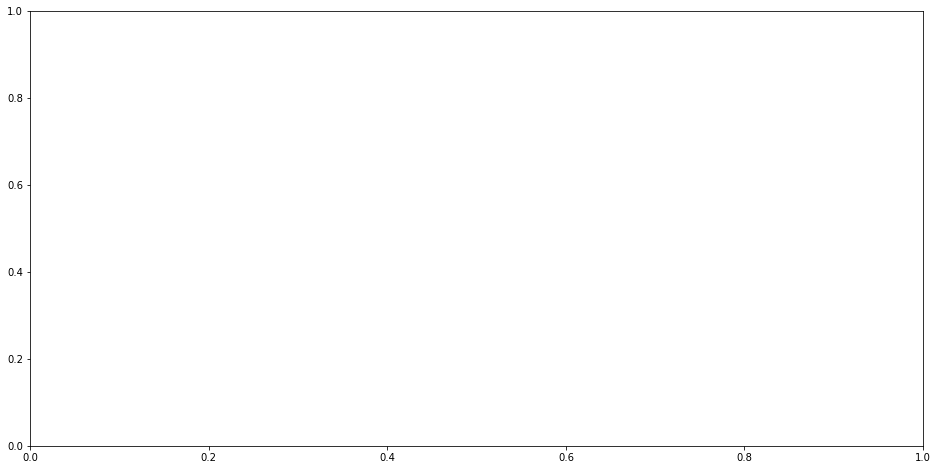

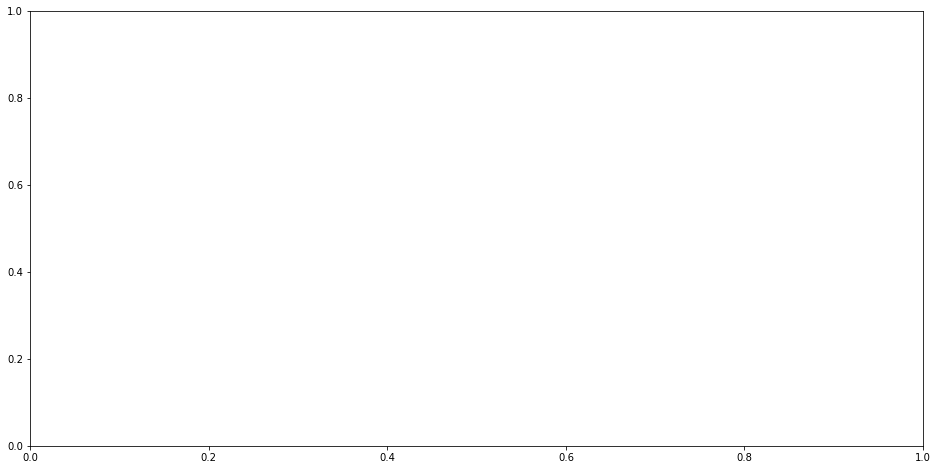

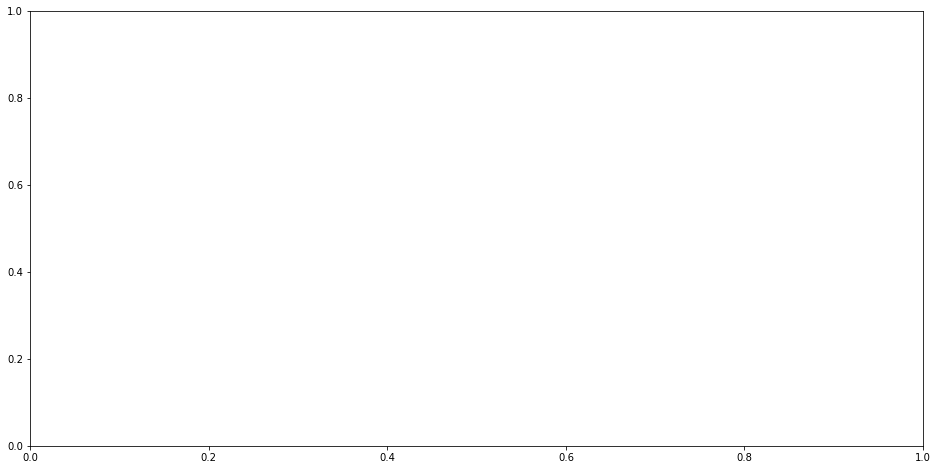

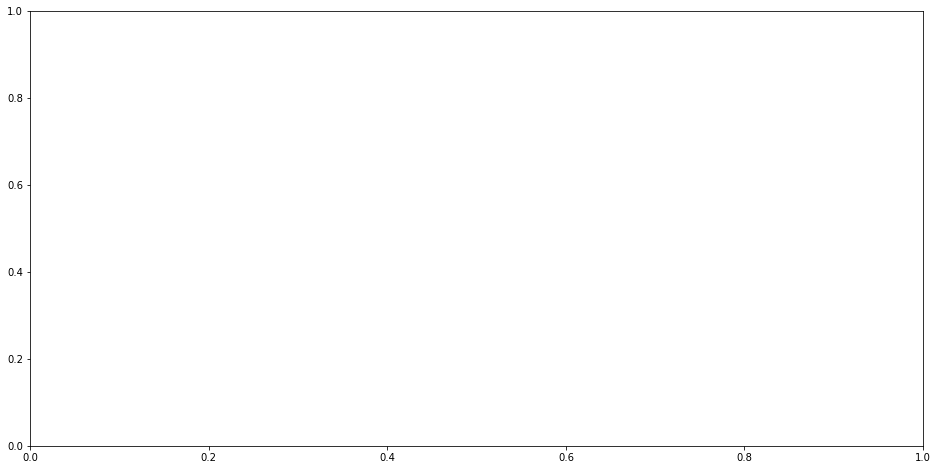

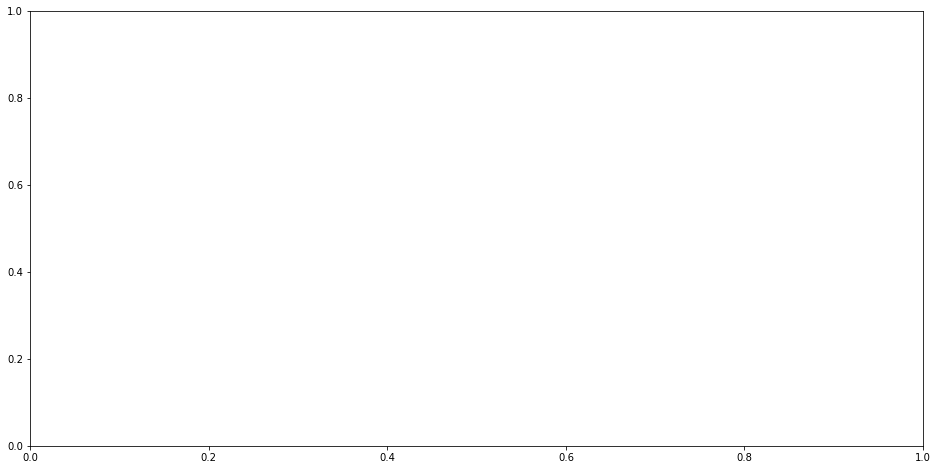

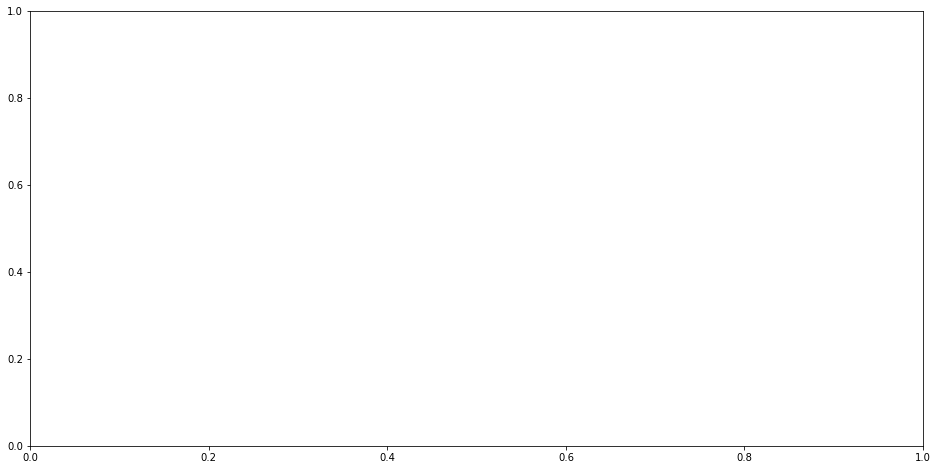

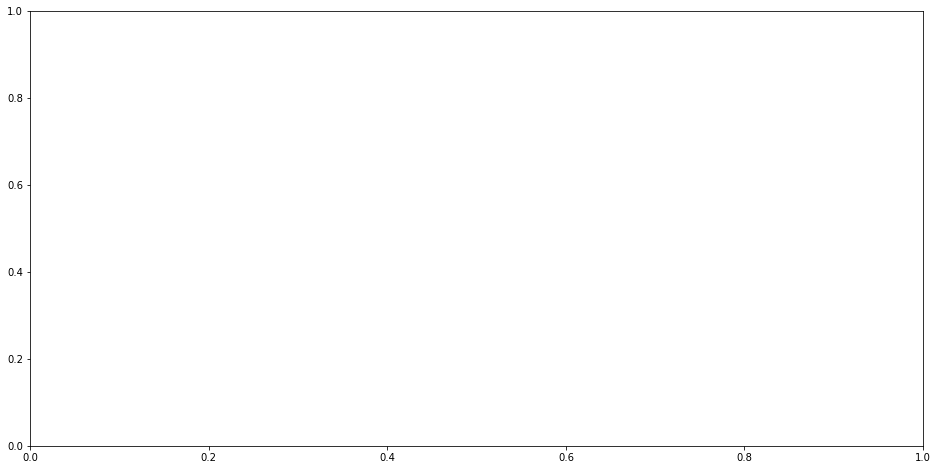

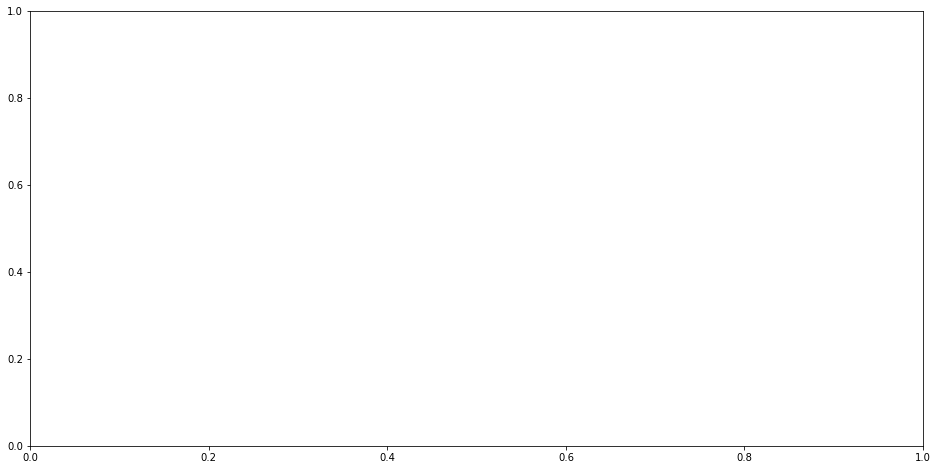

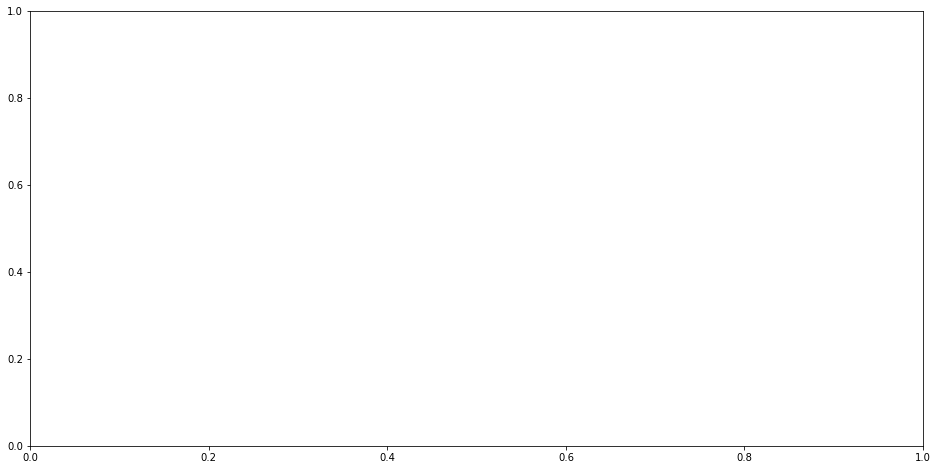

In [5]:
#Euler method with curviture 
#comparing continuum force from each site vs. force from average site

# define domain and lattice
dx = 0.1
dt = 0.001
tf = 400.0
t_max = int(tf/dt)
Lmax = 20.0 
Lmin = -5.0
Nx = int((Lmax-Lmin)/dx) +1
xs = linspace(Lmin, Lmax, Nx)

a0 = 1.0
nu = 1.0
htot = 10.0 # total hub protein available for binding

def xHubCurv(xp):
    return xp + hubRad * sin(phis)

hubRads = logspace(-1,2,3,base=2)*dx
hubRads = ones(1)*1.0

for hubRad in hubRads:
    phiCrit = pi * 0.5 # substrate can bind anything in [-phiCrit, phiCrit]
    NHub = int((2.0*phiCrit*hubRad)/dx)  # number of lattice sites that spike proteins can occupy
    if NHub == 1:
        phis = zeros(1) # force a single lattice site to be at the hub center (as in the point-like hub case)
    else:
        phis = linspace(-phiCrit,phiCrit,NHub)
        
    # initialize As and Ac for each run through
    h0 = htot/NHub # amount of available hub protein concentration at each lattice site
    As = zeros(Nx)
    As[xs > 0.0] = a0*1.0
    Ac = zeros(Nx)
    BHub0 = h0 * ones(NHub)
    BHub = BHub0.copy()
    AcBHub = zeros((NHub,Nx))
    xp = 0.0
    
    h02 = htot/(pi*hubRad)
    As2 = zeros(Nx)
    As2[xs > 0.0] = a0*1.0
    Ac2 = zeros(Nx)
    BHub02 = h02 * ones(NHub)
    BHub2 = BHub02.copy()
    AcBHub2 = zeros((NHub,Nx))
    xp2 = 0.0
    print(h0,h02)
    input()
    for t in range(t_max):
        xHub = xHubCurv(xp)
        stretchMat = sqrt((xp + hubRad*sin(phis[:,newaxis]) - xs)**2 + hubRad**2*(1-cos(phis[:,newaxis]))**2 )
        expMat = exp(-0.5*stretchMat**2)  # NHub by N matrix of boltzmann factors
        
        PNum = expMat*((BHub/BHub0))[:,newaxis]   #boltzmann factor reduced by ratio of sites available

        # find the center of mass for the hub protein distribution
        centerDenom = trapz(BHub0-BHub,x=xHub)
        if centerDenom < 1e-8:# was an issue when centerDenom was zero
            BHubCenter = xp
        else:
            BHubCenter = trapz((BHub0-BHub)*xHub,x=xHub)/centerDenom

        total_f2 = -trapz((BHubCenter2-xs)*Ac2,x=xs)
        
        
        AcBHub += (PNum*As- AcBHub*nu) * dt
        for i in range(NHub):
            ii = where(AcBHub[i]< 10**(-8))[0]
            AcBHub[i][ii] = 0.0
        Ac = trapz(AcBHub, x=phis, axis = 0)
        As += - trapz(PNum*As, x=phis, axis = 0) *dt
        BHub = BHub0-trapz(AcBHub, x=xs, axis = 1)
        xp += total_f * dt
        burnt = nu*Ac
        burnrate = trapz(burnt,x=xs)
        eff = total_f**2/burnrate    
        
        
        # for continuum of hub protein sites
        xHub2 = xHubCurv(xp2)
        diffMat2 = abs(xHub2[:,newaxis] - xs)
        stretchMat2 = sqrt((xp2 + hubRad*sin(phis[:,newaxis]) - xs)**2 + hubRad**2*(1-cos(phis[:,newaxis]))**2 )
        expMat2 = exp(-0.5*stretchMat2**2)  # NHub by N matrix of boltzmann factors
        
        PNum2 = expMat2*((BHub2/BHub0))[:,newaxis]   #boltzmann factor reduced by ratio of sites available

        total_f2 = trapz(trapz(diffMat2*AcBHub2,x=xs, axis = 1),x=xHub2,axis =0)
        
        
        AcBHub2 += (PNum2*As2- AcBHub2*nu) * dt
        for i in range(NHub):
            ii = where(AcBHub2[i]< 10**(-8))[0]
            AcBHub2[i][ii] = 0.0
        Ac2 = trapz(AcBHub2, x=phis, axis = 0)
        As2 += - trapz(PNum2*As2, x=phis, axis = 0) *dt
        BHub2 = BHub0-trapz(AcBHub2, x=xs, axis = 1)
        xp2 += total_f2 * dt
        burnt2 = nu*Ac2
        burnrate2 = trapz(burnt2,x=xs)
        eff2 = total_f2**2/burnrate2 
        
        if t % 1000 == 0:
            fig, axs = plt.subplots(figsize = (16,8))
            display.clear_output(wait=True)
            plot(xs,Ac, label = 'Ac')
            plot(xs,As, label = 'As')
            plot(xHub, BHub0-BHub, label = '$B_{hub}$')
            plot(xs,Ac2, label = 'Ac2')
            plot(xs,As2, label = 'As2')
            plot(xHub2, BHub0-BHub2, label = '$B_{hub2}$')
            legend()
            display.display(gcf())
            cla()
        
        if xp > Lmax - 10.0:
            break
    
print(NHub)